In [1]:
import os
import torch.backends.cudnn as cudnn
import yaml
from train import train
from utils import AttrDict
import pandas as pd
import warnings
import matplotlib.pyplot as plt

plt.style.use('seaborn-pastel')
warnings.filterwarnings("ignore") 

In [2]:
cudnn.benchmark = True
cudnn.deterministic = False

In [3]:
def get_config(file_path):
    with open(file_path, 'r', encoding="utf8") as stream:
        opt = yaml.safe_load(stream)
    opt = AttrDict(opt)
    if opt.lang_char == 'ar':
        characters = ''
        for data in opt['select_data'].split('-'):
            csv_path = os.path.join(opt['train_data'], data, 'labels.csv')
            df = pd.read_csv(csv_path, sep='^([^,]+),', engine='python', usecols=['filename', 'words'], keep_default_na=False)
            all_char = ''.join(df['words'])
            characters += ''.join(set(all_char))
        characters = sorted(set(characters))
        opt.character= ''.join(characters)
    else:
        opt.character = opt.number + opt.symbol + opt.lang_char
    os.makedirs(f'./saved_models/{opt.experiment_name}', exist_ok=True)
    return opt

# Custom hypertuning

## Utilities Documentation
The purpose of the hypertuning section, is to automate the prosses of evaluating different model parameters to find the set of best parameters for final training. And the process of picking up the best model will be based on the F1 score.
### *print_table(models, header)*
This method prints a table
> **models**: *AttrDict* + **header**: *list*
- models contains key: model name + value: config parameters
- header contains list of target values we want to display

### *remove_duplicates(models, criterias)*
Remove any duplicates 
> **models**: *AttrDict* + **criterias**: *list*  
- models contains key: model name + value: config parameters
- criterias contains list of target values we want to evaluate for duplicates

### *create_parameters(num_epochs, folds)*
This method creates at random fold # of models, where each model's parameters are uniformly from *config* after creation removes any duplicated models and prints these models.
> **num_epochs**: *int* + **folds**: *int*
- num_epochs is the number of epochs to train all models
- folds is the number of models to create

### *show_metrics(metrics)*
This method displays the metrcis (Accuracy, F1_Score) of all models after hypertuning has completed
> **metrics**: *AttrDict*
- metrics contains key: model name + value: metrcis result form training

### **hyper_parameter_tuning(num_epochs, folds)**
This method will call create_parameters and the for each model in the parameter will train it and save metrics results.
> **num_epochs**: *int* + **folds**: *int*
- num_epochs is the number of epochs to train all models
- folds is the number of models to create

In [4]:
import copy
import numpy as np
from datetime import date

def print_table(models, header, border=16):
    """
        Pretty print the tabel
        header: the columns we care about -> list
        models: the models that we will print -> Attrdict
    """
    columns = ''
    for _ in range(len(header)+1):
        columns += '{:<13}|'   
    # Table head
    print(columns.format('Model',*header))
    print('-'*(border * (len(header))))  
    
    for model, params in models.items():
        values = []
        for head in header:
            values.append(params[head])
        
        # Single row   
        print(columns.format(model, *values))
        
    # Table end
    print('-'*(border * (len(header))))
    print()
    
def remove_duplicates(models, criterias):
    """
        This method removes models with same parameters
        
        criterias: parameters we are hypertuning -> list
        models: all the models created -> Attrdict
    """
    result = AttrDict()
    for model, values in models.items():
        target_val = AttrDict()
        
        for key, value in values.items():
            if key in criterias:
                target_val[key] = models[model][key]
                setattr(target_val, key, target_val[key])
            else:
                target_val[key] = value
                setattr(target_val, key, target_val[key])
            
        if target_val not in result.values():
            result[model] = target_val
            
    return result
    
def create_parameters(num_epochs, folds):
    """
        This method return a dictionary of different model configs
        Will tune [lr, beta1, eps, batch_size, optim, hidden_size]
    """
    config ={
        'lr': [0.1, 0.5, 1.0, 1.5],
        'beta1': [0.9, 0.95, 0.99],
        'eps': [1e-8, 1e-6],
        'batch_size': [16, 32, 64],
        'optim': [0], # NOTE: When working with adam lr needs to be <0.1
        'hidden_size':[162, 200, 224, 256, 300, 324, 356],
        'contrast_adjust': np.arange(0, 1, 0.2).tolist(),
        'num_iter': [num_epochs],
        'valInterval': [round(num_epochs*0.5)]
    }
    config_params = config.keys()
    
    models = {}
    models['base'] = get_config("config_files/base_config.yaml")
    models['base'].num_iter = num_epochs
    models['base'].valInterval = round(num_epochs*0.5)
    
    # uniform and random search
    while folds > 0:
        opt = copy.deepcopy( models['base'])
        
        for key, value in models['base'].items():
            if key in config_params:
                random = np.random.randint(0, len(config[key]))
                opt[key] = config[key][random]
                setattr(opt, key, opt[key])
            else:
                opt[key] = value
                setattr(opt, key, value)
                
        uniq_ID = 'tune_'+ str(folds) +'_' + str(date.today()).replace('-','_')
        opt['experiment_name'] = uniq_ID
        setattr(opt, 'experiment_name', uniq_ID)
        os.makedirs(f'./saved_models/{opt.experiment_name}', exist_ok=True)

        models[f'tune_{folds}'] = opt
        folds -= 1
        
    params = list(config_params)
    params.remove("valInterval")
    params.remove("num_iter")
    
    # Remove any duplicate models
    models=remove_duplicates(models, params)
    
    # Display all models that will be trained
    print_table(models, params)
    
    return models

def show_metrics(metrics):
    """
        Show the metrics
    """
    stats = metrics[list(metrics.keys())[0]].keys()
    border = 20
    print_table(metrics, stats, border)
    show_plots(metrics)
    
def show_plots(metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    show_scatter_plot(metrics, ax1)
    
    for key in metrics:    
        ax2.scatter(metrics[key]['Accuracy'], metrics[key]['F1_score'], label=key)

    ax2.legend()
    plt.show()

def show_scatter_plot(metrics, axs):
    X = metrics.keys()
    Y = []
    Z = []

    for x in X:
        y = metrics[x]['Accuracy']
        z = metrics[x]['F1_score']

        Y.append(y)
        Z.append(z)

    df = pd.DataFrame(np.c_[Y,Z], index=X, columns=['Accuracy', 'F1_score'])
    df.plot.barh(ax=axs)


  
def hyper_parameter_tuning(num_epochs=10,folds=8):
    """
        num_epocs: how many epocs to run each model
        folds: number of model variations (no duplicates)
    """
    models = create_parameters(num_epochs, folds)
    metrics ={}
    for model in models.keys():
        print(f'current model training :~ {model} ')
        metrics[model] = train(models[model], amp=False, logs=False)
   
    print()
    print('-' * 80)
        
    # TODO: print stats of the models results
    show_metrics(metrics)

Model        |lr           |beta1        |eps          |batch_size   |optim        |hidden_size  |contrast_adjust|
----------------------------------------------------------------------------------------------------------------
base         |1.4          |0.9          |1e-09        |32           |0            |256          |0.0          |
tune_10      |1.0          |0.99         |1e-06        |32           |0            |356          |0.6000000000000001|
tune_9       |0.5          |0.99         |1e-06        |32           |0            |200          |0.6000000000000001|
tune_8       |1.0          |0.95         |1e-08        |16           |0            |200          |0.4          |
tune_7       |0.5          |0.99         |1e-06        |64           |0            |300          |0.0          |
tune_6       |1.5          |0.9          |1e-08        |32           |0            |300          |0.2          |
tune_5       |0.5          |0.95         |1e-08        |32           |0            |

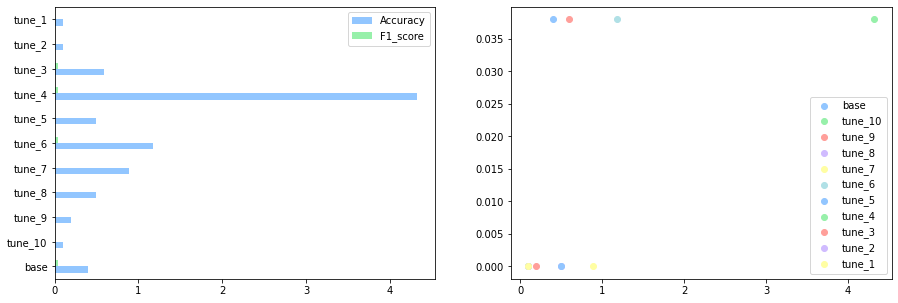

In [5]:
hyper_parameter_tuning(num_epochs=1000, folds=10)